# Paso 1: Importar Librerías de Python


In [ ]:
pip install scikit-surprise

In [ ]:
pip install --user nltk

In [ ]:
!pip install vaderSentiment

In [ ]:
!pip install joblib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive

from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, Dot
from keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
import nltk
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

import warnings
warnings.filterwarnings("ignore")


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Paso 2: Lectura del Dataset

In [ ]:
# Suponiendo que tu DataFrame se llama df
df = pd.read_csv('/content/drive/MyDrive/EspecializacionA&DS/Monografia/2doSemestre/DataFinal_Amazon.csv')  # Descomenta y proporciona la ruta si estás cargando un archivo CSV

In [ ]:
df.shape

(4800571, 10)

# Paso 3: Reducción de Datos


In [ ]:
# Tomar una muestra del 10% del dataset, si es necesario
#df = df.sample(frac=0.1, random_state=42)

In [ ]:
df.shape

(4800571, 10)

In [ ]:
df["reviewText"].fillna("", inplace=True)
df["summary"].fillna("", inplace=True)

In [ ]:
df["reviewText"] = df["reviewText"].astype(str)
df["summary"] = df["summary"].astype(str)

# Analisis de Sentimientos

In [ ]:
df.head(5)

,overall,reviewerID,asin,reviewText,summary,brand,price,extracted_rank,reviewDate,category
0,3.0,A1BB77SEBQT8VX,B00007GDFV,mother - in - law wanted it as a present for h...,bought as a present,Buxton,16.95,43930,2013-09-22,FASHION
1,3.0,A1BB77SEBQT8VX,B00007GDFV,mother - in - law wanted it as a present for h...,bought as a present,Buxton,16.95,43930,2013-09-22,FASHION
2,3.0,AHWOW7D1ABO9C,B00007GDFV,"Item is of good quality. Looks great, too. But...",Buxton heiress collection,Buxton,16.95,43930,2013-07-17,FASHION
3,3.0,AHWOW7D1ABO9C,B00007GDFV,"Item is of good quality. Looks great, too. But...",Buxton heiress collection,Buxton,16.95,43930,2013-07-17,FASHION
4,3.0,AKS3GULZE0HFC,B00007GDFV,I had used my last el-cheapo fake leather ciga...,Top Clasp Broke Within 3 days!,Buxton,16.95,43930,2013-04-13,FASHION


In [ ]:
analizador = SentimentIntensityAnalyzer()

In [ ]:
# Función para calcular el puntaje de sentimiento de un texto
def get_sentiment_score(text):
    return analizador.polarity_scores(text)["compound"]

In [ ]:
# Función para paralelizar la tarea
def parallel_sentiment(data, func, n_jobs=-1):
    return Parallel(n_jobs=n_jobs)(delayed(func)(text) for text in data)

In [ ]:
# Aplicar la función de análisis de sentimientos en paralelo
df["reviewText_sentiment"] = parallel_sentiment(df["reviewText"], get_sentiment_score)

In [ ]:
# Ver el DataFrame con las nuevas columnas
print(df[["asin", "reviewText_sentiment"]])

               asin  reviewText_sentiment
0        B00007GDFV                0.4215
1        B00007GDFV                0.4215
2        B00007GDFV                0.8823
3        B00007GDFV                0.8823
4        B00007GDFV                0.9822
...             ...                   ...
4800566  B01HJ7J4PI                0.8176
4800567  B01HJ7J4PI                0.9358
4800568  B01HJ7J4PI                0.4754
4800569  B01HJ7J4PI                0.8519
4800570  B01HJ7J4PI                0.0000

[4800571 rows x 2 columns]


In [ ]:
# Ajusta el agrupamiento por 'asin' para calcular los promedios de las tres columnas
grouped = df.groupby("asin").agg({
    "reviewText_sentiment": "mean"}).reset_index()

print(grouped)

              asin  reviewText_sentiment
0       0871167042              0.632713
1       1519588135              0.568186
2       1579652956              0.713937
3       1936023857              0.765550
4       5120053017              0.485311
...            ...                   ...
154021  B01HJCSCLK              0.653483
154022  B01HJD4BBE              0.582478
154023  B01HJDZM30              0.668714
154024  B01HJGJ9LS              0.455767
154025  B01HJHR8A6              0.575500

[154026 rows x 2 columns]


Está basado en el puntaje compound del VADER, que varía entre -1 y 1, donde -1 indica un sentimiento muy negativo, 1 un sentimiento muy positivo, y cerca de 0 neutral.

Interpretación:
Productos con puntajes altos en reviewText_sentiment generalmente tienen reseñas positivas. Los clientes tienden a hablar bien de ellos tanto en el cuerpo completo de la reseña como en el resumen.

Productos con puntajes bajos o negativos en las columnas de sentimiento probablemente tienen reseñas negativas o mixtas. Un puntaje negativo significa que hay más comentarios negativos que positivos.


#Clusterización basado en el analisis de sentimientos

In [ ]:
# 2. Normalización de los datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(grouped[['reviewText_sentiment']])

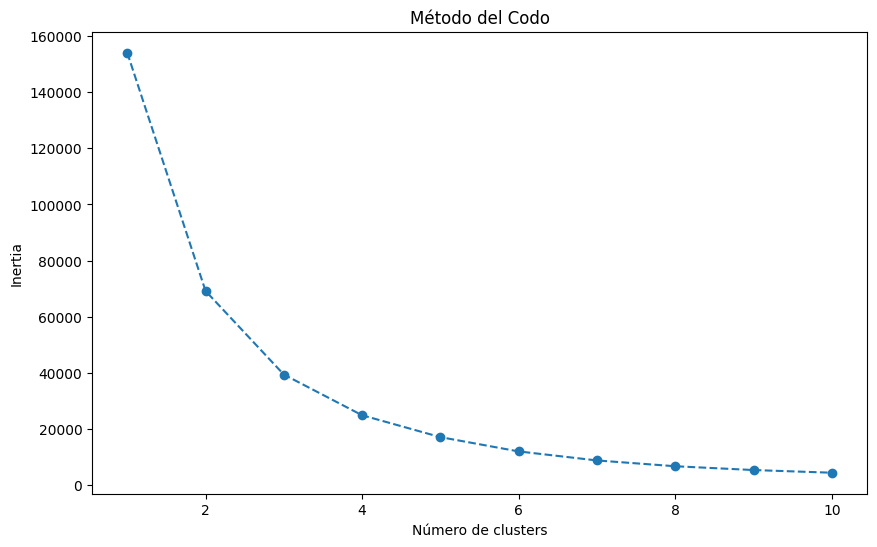

In [ ]:
# 3. Determinar el número óptimo de clusters usando el método del codo y la métrica de silueta

# Método del codo
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Una vez determinado el número óptimo de clusters, realiza la clusterización final
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
grouped['cluster'] = kmeans.fit_predict(scaled_features)

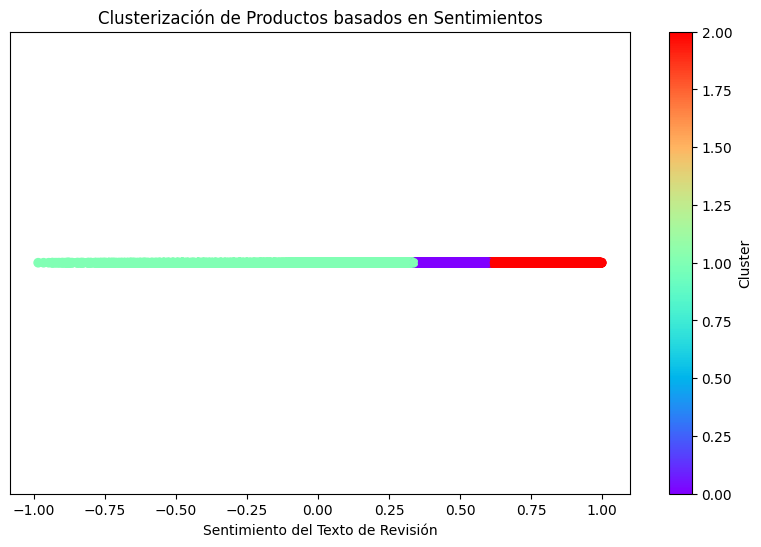

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Crear un valor de 'y' arbitrario o una secuencia de valores para la visualización
y_values = np.zeros(len(grouped))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(grouped['reviewText_sentiment'], y_values, c=grouped['cluster'], cmap='rainbow')
plt.title('Clusterización de Productos basados en Sentimientos')
plt.xlabel('Sentimiento del Texto de Revisión')
plt.colorbar(scatter, label='Cluster')
plt.yticks([])  # Ocultar los ticks del eje y, ya que no representan datos significativos en este caso
plt.show()


Ejes:
Eje X - Sentimiento Promedio: Este eje representa el sentimiento promedio de las revisiones para un producto. Los valores van desde -1 a 1, donde:

-1 indica un sentimiento extremadamente negativo.
0 indica neutralidad en el sentimiento.
1 indica un sentimiento extremadamente positivo.
Eje Y - Sentimiento del Texto de Revisión: Este eje representa el sentimiento del texto completo de la revisión. Al igual que el eje X, los valores varían de -1 a 1, representando sentimientos desde extremadamente negativos hasta extremadamente positivos.

Interpretación:
Cluster Rojo: Los productos en este grupo tienden a tener revisiones que varían desde neutral hasta muy negativas en términos de sentimiento. En su mayoría, estos productos tienen una baja calificación de sentimiento promedio y un bajo sentimiento en el texto de la revisión.

Cluster Verde: Los productos en este cluster tienen revisiones con un sentimiento que varía desde neutral hasta positivo. Están en la parte media en términos de sentimiento promedio y sentimiento del texto de revisión.

Cluster Púrpura: Estos productos tienen revisiones con sentimientos predominantemente positivos. Tienen altos valores tanto para el sentimiento promedio como para el sentimiento del texto de la revisión.

Conclusiones:
Segmentación de Productos: Con esta clusterización, puedes segmentar tu conjunto de productos en aquellos que generalmente reciben críticas positivas, neutrales o negativas.

Toma de Decisiones: Si estás en una posición de tomar decisiones relacionadas con los productos, podrías considerar revisar más a fondo los productos en el cluster rojo para identificar problemas y áreas de mejora.

Estrategias de Marketing y Venta: Los productos en el cluster púrpura, que tienen críticas predominantemente positivas, podrían ser promocionados más intensamente, ya que es probable que sean bien recibidos por nuevos clientes.

Finalmente, es esencial considerar el contexto del negocio y el producto al interpretar estos resultados. Si bien la clusterización proporciona una visión general basada en sentimientos, siempre es útil combinar estos hallazgos con otras métricas y análisis cualitativos para obtener una comprensión completa.

In [ ]:
grouped.head(5)

,asin,reviewText_sentiment,cluster
0,0871167042,0.632713,2
1,1519588135,0.568186,0
2,1579652956,0.713937,2
3,1936023857,0.765550,2
4,5120053017,0.485311,0


In [ ]:
# Cambiar los nombres de los clusters
cluster_names = {1: 'Negativo', 0: 'Neutro', 2: 'Positivo'}
grouped['cluster'] = grouped['cluster'].replace(cluster_names)

# Mostrar los primeros registros del DataFrame modificado
print(grouped.head())


         asin  reviewText_sentiment   cluster  cluster_hdbscan
0  0871167042              0.632713  Positivo                0
1  1519588135              0.568186    Neutro                2
2  1579652956              0.713937  Positivo                0
3  1936023857              0.765550  Positivo               -1
4  5120053017              0.485311    Neutro               -1


In [ ]:
pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 29.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039156 sha256=40be10ff74b2832b7c10ba0c1966df8b8fc76582108432f79848484a4f5a3d29
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.5
    Uninstalling Cython-3.0.5:
      Successfully uninstalled Cython-3.0.5


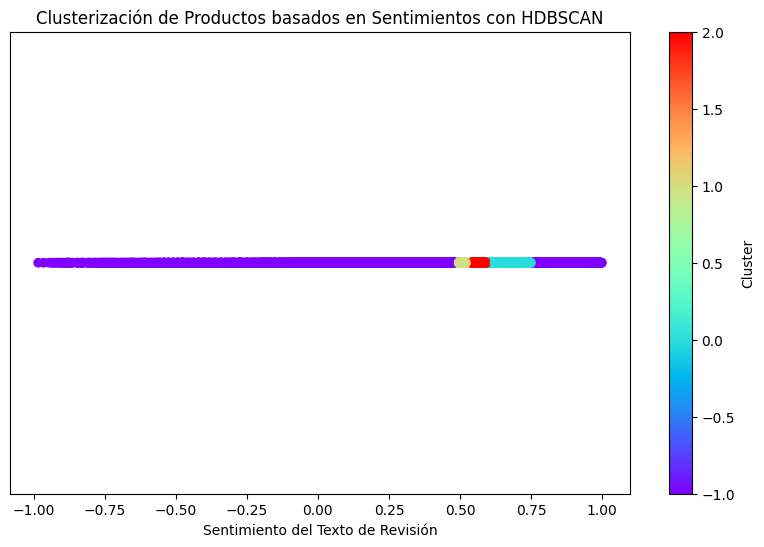

In [ ]:
import hdbscan
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Aplicar HDBSCAN
hdbscan_cluster = hdbscan.HDBSCAN(min_samples=20, min_cluster_size=15000)
grouped['cluster_hdbscan'] = hdbscan_cluster.fit_predict(scaled_features)

# Visualizar los resultados
plt.figure(figsize=(10, 6))
scatter = plt.scatter(grouped['reviewText_sentiment'], np.zeros(len(grouped)), c=grouped['cluster_hdbscan'], cmap='rainbow')
plt.title('Clusterización de Productos basados en Sentimientos con HDBSCAN')
plt.xlabel('Sentimiento del Texto de Revisión')
plt.colorbar(scatter, label='Cluster')
plt.yticks([])  # Ocultar los ticks del eje y
plt.show()


In [ ]:
# Guardar el DataFrame modificado como un archivo CSV
grouped.to_csv('sentimientos_productos.csv', index=False)